# p-value calculation


In [9]:
import numpy as np
import scipy.linalg as sl
from scipy import integrate as sint

def imhof(u, x, eigs, output='cdf'):
    theta = 0.5 * np.sum(np.arctan(eigs[:, None] * u), axis=0) - 0.5 * x * u
    rho   = np.prod((1.0 + (eigs[:, None] * u)**2)**0.25, axis=0)
    return (np.sin(theta) / (u * rho)) if output=='cdf' else (np.cos(theta) / rho)

def gx2cdf(eigr, xs, cutoff=1e-36, limit=200, epsabs=1e-7):
    eigs = eigr[:cutoff] if cutoff > 1 else eigr[np.abs(eigr) > cutoff]
    return np.array([0.5 - sint.quad(lambda u: float(imhof(u, x, eigs)),
                                     0, np.inf, limit=limit, epsabs=epsabs)[0] / np.pi
                     for x in np.atleast_1d(xs)])

def spectral_and_pvalue_from_yQ( Q, Sigma_y, os_val, *,
                                complex_mode=False,
                                cutoff=1e-12,
                                tol_ratio=1e-12,
                                jitter_ratio=None):
    """
    Purpose
    -------
    Given a quadratic form D = y^T Q y under H0 with y ~ N(0, Sigma_y),
    compute the (right-tail) p-value P{ D >= os_val | H0 } via Imhof's method.

    Math mapping
    ------------
    1) Stabilize Sigma_y to be PSD:
       - Eigen-decompose Sigma_y = V diag(w) V^T
       - Clip tiny negative eigenvalues (relative to the mean positive one).
       - Rebuild PSD covariance Cy_psd = V diag(w_+) V^T.
    2) Whiten by Cholesky: Cy_psd = L L^T (or L^T L), set S = L^T Q L.
       If y ~ N(0, Cy_psd), then y = L ε with ε ~ N(0, I), hence
         D = y^T Q y = ε^T (L^T Q L) ε = ε^T S ε.
    3) Diagonalize S = U diag(λ) U^T, then
         D  = Σ_i λ_i z_i^2,   z = U ε ~ N(0, I).
       Therefore D follows a generalized chi-square with weights λ_i.
    4) Use Imhof to evaluate F_D(os_val), then p_right = 1 - F_D(os_val).
       If `complex_mode=True`, duplicate eigenvalues (models complex basis).

    Parameters
    ----------
    Q : (rA, rA)
        Symmetric matrix of the quadratic statistic in the reduced basis
        (it can be already normalized outside; here we just use it as-is).
    Sigma_y : (rA, rA)
        Covariance of y under H0 (e.g. Sigma_y = G_A^T (φ_N - Σ) G_A).
    os_val : float
        Observed value d_obs of the statistic D = y^T Q y.
    complex_mode : bool
        If True, duplicate each eigenvalue λ_i → models complex representation
        (real/imag parts) where each degree occurs twice.
    cutoff : float
        |λ|-cutoff used inside gx2cdf/Imhof to drop extremely small weights.
    tol_ratio : float
        Relative tolerance to clip tiny negative eigenvalues of Sigma_y.
        We compare min negative |w| to mean positive eigenvalue; if the ratio
        exceeds tol_ratio, we raise, else we clamp negatives to zero.
    jitter_ratio : float or None
        If Cholesky of the PSD-fixed covariance fails (semi-definiteness),
        add a diagonal jitter = jitter_ratio * mean_pos to make it Choleskyable.
        If None, uses tol_ratio.

    Returns
    -------
    p_right : float
        Right-tail p-value P{ D >= os_val | H0 }.
    """

    # --- 1) PSD repair of Sigma_y: clip tiny negative eigenvalues relative to mean positive ---
    # Eigendecompose Sigma_y
    w, V = sl.eigh(Sigma_y, check_finite=False)
    pos = (w > 0.0)
    mean_pos = float(np.mean(w[pos])) if np.any(pos) else float(np.mean(np.abs(w))) if w.size else 0.0
    if mean_pos <= 0.0:
        # Extreme degeneracy: no positive spectrum → cannot stabilize to a proper covariance
        raise np.linalg.LinAlgError("Sigma_y has no positive spectrum; cannot stabilize.")

    neg = (w < 0.0)
    if np.any(neg):
        worst = float(np.max(np.abs(w[neg]) / mean_pos))
        if worst > tol_ratio:
            # Significant negative mass → likely model mismatch or numerical error too large
            raise np.linalg.LinAlgError(
                f"Sigma_y not PSD: min_eig={w.min():.3e}, mean_pos={mean_pos:.3e}, "
                f"ratio={worst:.3e} > tol_ratio={tol_ratio:.3e}"
            )
        # Clamp tiny negative eigenvalues to zero (stay PSD)
        w[neg] = 0.0

    # Rebuild stabilized covariance: Cy_psd = V diag(w_+) V^T
    # Use column scaling trick: V @ diag(w) @ V.T == (V * w) @ V.T
    Cy_psd = (V * w[None, :]) @ V.T

    # --- 2) Cholesky factor; if semi-definite, add a tiny jitter on the diagonal and retry ---
    if jitter_ratio is None:
        jitter_ratio = tol_ratio
    jitter = jitter_ratio * mean_pos
    try:
        L = np.linalg.cholesky(Cy_psd)
    except np.linalg.LinAlgError:
        L = np.linalg.cholesky(Cy_psd + jitter * np.eye(Cy_psd.shape[0]))

    # --- 3) Spectrum of S = L^T Q L (this is the weight matrix for the gen. chi-square) ---
    S = L.T @ Q @ L
    lam, U = sl.eigh(S, check_finite=False)

    # --- 4) Build λ-list depending on real/complex modeling ---
    # For complex models (e.g. exp(i 2πft)), each real DOF appears twice → duplicate λ
    lam_eff = np.repeat(lam, 2) if complex_mode else lam

    # --- 5) Imhof CDF at the observed value → right-tail p-value ---
    F = gx2cdf(lam_eff, [float(os_val)], cutoff=cutoff)[0]
    p_right = 1.0 - F
    return p_right

In [10]:
os_val, y, Q, Sigma_y = os_fourier.get_deflection_coordinates(par_dict)

p_right = spectral_and_pvalue_from_yQ(Q, Sigma_y,os_val)
print("p-right =", p_right  )

p-right = 0.11648567282946654


### Demonstration Plot
(By using the last element in the MCMC chain)

In [11]:


def gx2pdf(eigr, xs, cutoff=1e-6, limit=100, epsabs=1e-6):
    """Calculate the GX2 PDF as a function of sx, based off of eigenvalues 'eigr'"""

    # Eigenvalue cutoff for efficiency
    eigs = eigr[:cutoff] if cutoff > 1 else eigr[np.abs(eigr) > cutoff]

    return np.array([sint.quad(lambda u: float(imhof(u, x, eigs, output='pdf')),
                                                0, np.inf, limit=limit, epsabs=epsabs)[0] / (2*np.pi) for x in xs])



def plot_pdf(Q, Sigma_y, os_val, *, complex_mode=False,
             cutoff=1e-12, limit=200, epsabs=1e-7,
             npts=800, std_span=6.0, ax=None):
    """
    Plot the generalized chi-square (GX^2) PDF under H0 for the quadratic form
    D = y^T Q y, and mark the observed statistic d_obs.

    Parameters
    ----------
    Q : (rA, rA)
        Normalized filter/statistic matrix (should be symmetric).
    Sigma_y : (rA, rA)
        Covariance of y under H0 (e.g. Σ_y = G_A^T (φ_N - Σ) G_A).
    os_val : float
        Observed statistic d_obs = y^T Q y.
    complex_mode : bool, default=False
        If True, duplicate eigenvalues to represent complex DOF.
    cutoff : float
        Cutoff for eigenvalues in gx2pdf integration.
    limit, epsabs : integration controls
        Passed to scipy.integrate.quad for the PDF integral.
    npts : int
        Number of grid points for plotting the PDF curve.
    std_span : float
        Range span in units of σ around μ for plotting (±kσ).
    ax : matplotlib axis or None
        If given, plot into this axis; else create a new figure.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object.
    ax : matplotlib.axes.Axes
        The axis with the plotted PDF.
    lam_eff : ndarray
        Effective eigenvalues (duplicated if complex_mode=True).
    mu : float
        Mean of the GX^2 distribution (Σ λ_i).
    sigma : float
        Standard deviation (sqrt(2 Σ λ_i^2)).
    p_right : float (not returned here, but typically computed elsewhere)
        Right-tail probability if needed.
    p_left : float (idem).
    """

    # --- 1) Whiten covariance by Cholesky ---
    # Sigma_y = L L^T, then S = L^T Q L
    L   = np.linalg.cholesky(Sigma_y)
    S   = (L.T @ Q @ L)

    # --- 2) Eigenvalues of S determine the GX^2 law ---
    lam, U = sl.eigh(S)
    lam_eff = np.repeat(lam, 2) if complex_mode else lam

    # --- 3) Invariants: mean and variance under H0 ---
    mu    = float(lam_eff.sum())                 # E[D] = Σ λ_i
    sigma = float(np.sqrt(2.0*np.sum(lam_eff**2))) if lam_eff.size else 0.0

    # --- 4) Determine plotting range around μ ± kσ, ensure os_val included ---
    if sigma > 0:
        xmin = min(mu - std_span*sigma, os_val) - 0.05*sigma
        xmax = max(mu + std_span*sigma, os_val) + 0.05*sigma
    else:
        xmin = min(mu-1.0, os_val-1.0)
        xmax = max(mu+1.0, os_val+1.0)
    xs = np.linspace(xmin, xmax, int(npts))

    # --- 5) Evaluate the PDF on the grid ---
    pdf = gx2pdf(lam_eff, xs, cutoff=cutoff, limit=limit, epsabs=epsabs)

    # --- 6) Plot ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.2, 4.2))
    else:
        fig = ax.figure

    ax.plot(xs, pdf, lw=2, label='GX$^2$ PDF under $H_0$')
    ax.axvline(os_val, ls='--', lw=1.8,
               label=fr'$d_{{obs}}={os_val:.3g}$')
    ax.axvline(mu, color='k', lw=1.0, alpha=0.5, ls=':',
               label=fr'$\mu_0=\sum\lambda={mu:.3g}$')
    ax.set_xlabel('x')
    ax.set_ylabel('density')
    ax.set_title('Generalized $\chi^2$ PDF from $(Q, \Sigma_y)$')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.25)

    return fig, ax

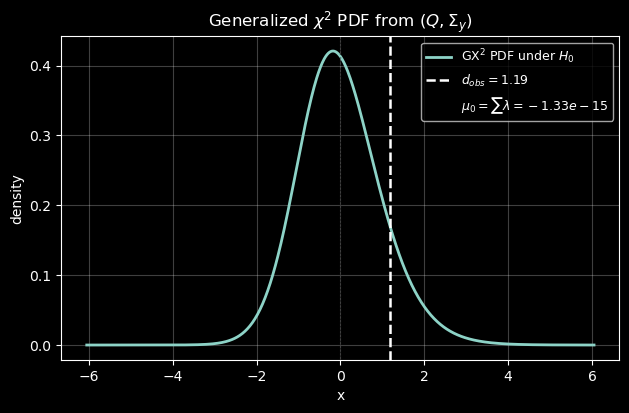

In [12]:
os_val, y, Q, Sigma_y = os_fourier.get_deflection_coordinates(big_array[-1])
fig, ax = plot_pdf(Q, Sigma_y, os_val, complex_mode=False,cutoff=1e-12, npts=800)
plt.show()

### posterior-predictive p 
(By using the last 100 elements in the MCMC chain)

In [13]:
num_p=100
p_arr=[]
for i in range(num_p):
    os_vali, yi, Qi, Sigma_yi = os_fourier.get_deflection_coordinates(big_array[-(i+1)])
    p_righti = spectral_and_pvalue_from_yQ( Qi, Sigma_yi,os_vali)
    p_arr.append(p_righti)
p_arr=np.array(p_arr)
p_ave=np.average(p_arr)
print(p_ave)

0.11624540696648011
